<a href="https://colab.research.google.com/github/abomhold/Catagorical-Regression-Analysis/blob/master/RF_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pull data sets from GitHub and combine

By Austin B

In [2]:
import pandas as pd
!pip install --user openpyxl

# Reorder tree data by temp with column name as new feature
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
tree = pd.read_excel(url1)
print(tree)
tree = tree.melt(id_vars=['Date Time'], var_name='Temperature Source', value_name='Temperature')
print(tree)

# Format the date time column and set as index
tree['Date Time'] = pd.to_datetime(tree['Date Time'], format='%m/%d/%Y %H:%M')
tree.set_index('Date Time', inplace=True)
print(tree)

# Set the date time as a pd.datetime column and to the index
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
weather = pd.read_excel(url2)

# Set the date_time as a pandas datetime and the index
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather.set_index('datetime', inplace=True)

# Reindex weather to match the tree data frame
weather = weather.reindex(tree.index, method='nearest')

# Combine the data frames
combined = pd.concat([tree, weather], axis=1)
print(combined)

               Date Time  S4.5cm@1m  E9cm@1m  N13.5cm@1m  E4.5cm@2m  N9cm@2m  \
0    2022-08-21 00:01:51      25.18    26.25       24.62      25.62    26.12   
1    2022-08-21 00:05:07      25.18    26.18       24.62      25.68    26.12   
2    2022-08-21 00:08:23      25.12    26.18       24.62      25.62    26.12   
3    2022-08-21 00:11:38      25.18    26.18       24.56      25.62    26.06   
4    2022-08-21 00:14:54      25.12    26.18       24.62      25.62    26.06   
...                  ...        ...      ...         ...        ...      ...   
3374 2022-08-28 23:45:31      25.18    25.68       25.12      25.62    26.06   
3375 2022-08-28 23:48:46      25.18    25.68       25.06      25.62    26.06   
3376 2022-08-28 23:52:02      25.18    25.68       25.06      25.62    26.06   
3377 2022-08-28 23:55:17      25.18    25.68       25.06      25.62    26.06   
3378 2022-08-28 23:58:32      25.18    25.68       25.00      25.62    26.06   

      W13.5cm@2m  N4.5cm@3m  W9cm@3m  S

## Clean the data and output to CSV

In [3]:
# Combine the data frames (duplicate to support only running second half of script)
combined = pd.concat([tree, weather], axis=1)

# clean the temperature source column
combined['Temperature Source'] = combined['Temperature Source'].apply(
    lambda x: x.replace('@', ' ')
               .replace('cm', '')
               .replace(',', ' ')
               .replace('m', '')
               )

# Replace S/N/E/W with degrees
directionDict = {'S': 0, 'N': 180, 'E': 270, 'W': 90}
combined['direction'] = combined['Temperature Source'].apply(
    lambda x: directionDict.get(x.split(' ')[0][0])
    ).astype(int)

# Convert the column header to a depth
combined['depth'] = combined['Temperature Source'].apply(
    lambda x: x.split(' ')[0][1:] if not x.split(' ')[0][1:].endswith("_Ext_Tep") else 0
    ).astype(float)

# Convert the column header to a height
combined['height'] = combined['Temperature Source'].apply(
    lambda x: x.split(' ')[1]
    ).astype(float)

# Reorder the columns and drop redundant columns
combined = combined.drop('Temperature Source', axis=1)
cols = combined.columns.tolist()
cols = [cols[0]] + cols[-3:] + cols[1:7]
combined = combined[cols]

# rename columns
combined.index.names = ['date_time']
combined.columns = ['temperature', 'direction', 'depth', 'height', 'wind_speed',
                    'wind_direction', 'air_humidity', 'air_temperature',
                    'air_pressure', 'solar_DNI']

# Create a space column for the three spatial dimensions
# # Multiply all values to
# combined['space'] = combined[['direction', 'depth', 'height']].apply(list, axis=1)


print(combined)

# Save the cleaned data
combined.to_csv('./data.csv')

# Read the cleaned data
# with open('./data.csv') as f:
#     print(f.read())

                     temperature  direction  depth  height  wind_speed  \
date_time                                                                
2022-08-21 00:01:51        25.18          0    4.5     1.0      2.1758   
2022-08-21 00:05:07        25.18          0    4.5     1.0      2.0381   
2022-08-21 00:08:23        25.12          0    4.5     1.0      2.0381   
2022-08-21 00:11:38        25.18          0    4.5     1.0      2.0381   
2022-08-21 00:14:54        25.12          0    4.5     1.0      2.0381   
...                          ...        ...    ...     ...         ...   
2022-08-28 23:45:31        25.12         90    0.0     3.5      1.3129   
2022-08-28 23:48:46        25.12         90    0.0     3.5      1.3129   
2022-08-28 23:52:02        25.06         90    0.0     3.5      1.3129   
2022-08-28 23:55:17        25.00         90    0.0     3.5      1.3129   
2022-08-28 23:58:32        24.56         90    0.0     3.5      1.3129   

                     wind_direction  

## Random Forrest Regressor

In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

# Load the cleaned data
data = pd.read_csv('./data.csv', index_col='date_time')
# Shuffle data with fixed seed

############ DO NOT EDIT THE MODEL WITHOUT FIRST PERFORMING THIS STEP ##########
# It is crucial to the validity of our research
# Delete the first 5% of rows as a blind test sample
# This is for humans and models
data = data.sample(frac=1, random_state=42)
print(len(data))
# data = data.iloc[int(len(data) * 0.05):]
print(len(data))
################################################################################
# Define the target variable (temperature) and features
X = data.drop(['temperature'], axis=1)  # Drop target and unnecessary columns
y = data['temperature']

# Keep a copy of the feature names before scaling
feature_names = X.columns # Store column names here

# Add a nomalization step
scaler = RobustScaler()
X = scaler.fit_transform(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)
print(y_train)

33790
33790
[[-1.50000000e+00 -5.00000000e-01 -5.00000000e-01 ...  2.47805290e-01
   2.70938862e-01 -4.10399729e-05]
 [ 5.00000000e-01  0.00000000e+00  0.00000000e+00 ... -6.07962859e-01
   4.51172105e-02 -1.96791675e-03]
 [ 1.50000000e+00  0.00000000e+00 -5.00000000e-01 ...  9.47917839e-01
   7.09447520e-01  1.60791511e+00]
 ...
 [-5.00000000e-01 -1.00000000e+00  7.50000000e-01 ... -9.17360720e-01
   3.05218518e-01 -2.93085465e-03]
 [ 1.50000000e+00  0.00000000e+00 -5.00000000e-01 ...  2.25745639e-01
   2.13806102e-01  3.48339282e-04]
 [-5.00000000e-01  0.00000000e+00  5.00000000e-01 ... -4.79150253e-01
   4.93933325e-01 -2.86979518e-03]]
date_time
2022-08-24 18:51:16    25.00
2022-08-27 06:19:32    24.75
2022-08-21 09:43:13    26.75
2022-08-24 18:12:12    26.81
2022-08-27 04:34:49    25.12
                       ...  
2022-08-25 17:48:48    27.37
2022-08-21 00:27:57    25.75
2022-08-26 05:10:17    20.93
2022-08-21 19:05:51    27.12
2022-08-23 21:44:10    23.12
Name: temperature, Leng

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import check_random_state
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor

class CustomExtraTreesRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 random_state=None, criterion='squared_error', bootstrap=False,
                 max_features=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.criterion = criterion
        self.bootstrap = bootstrap
        self.max_features = max_features
        self.estimators_ = []

    def fit(self, X, y):
        # Input validation
        X, y = check_X_y(X, y)
        self.random_state_ = check_random_state(self.random_state)

        # Calculate max_features
        n_features = X.shape[1]
        if isinstance(self.max_features, float):
            self.max_features_ = max(1, int(self.max_features * n_features))
        elif isinstance(self.max_features, int):
            self.max_features_ = self.max_features
        elif self.max_features == "sqrt":
            self.max_features_ = max(1, int(np.sqrt(n_features)))
        elif self.max_features == "log2":
            self.max_features_ = max(1, int(np.log2(n_features)))
        else:
            self.max_features_ = n_features

        self.estimators_ = []
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state_.randint(0, 100000),
                criterion=self.criterion,
                splitter='random',
                max_features=self.max_features_
            )

            if self.bootstrap:
                # Optional bootstrapping (not default for Extra Trees)
                X_sample, y_sample = resample(X, y,
                    random_state=self.random_state_.randint(0, 100000))
            else:
                # Use full dataset (default for Extra Trees)
                X_sample, y_sample = X, y

            tree.fit(X_sample, y_sample)
            self.estimators_.append(tree)

        return self

    def predict(self, X):
        # Check if model has been fitted
        check_is_fitted(self)
        X = check_array(X)

        # Get predictions from all trees and average them
        predictions = np.array([tree.predict(X) for tree in self.estimators_])
        return np.mean(predictions, axis=0)

    def score(self, X, y):
        """Returns the coefficient of determination R^2 of the prediction."""
        from sklearn.metrics import r2_score
        return r2_score(y, self.predict(X))

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import numpy as np
custom_ex_rf_regressor = CustomExtraTreesRegressor(n_estimators = 100, random_state = 0, criterion='poisson')
custom_ex_rf_regressor.fit(X_train, y_train)
y_pred = custom_ex_rf_regressor.predict(X_test)
print("Absolute error is", np.max(np.abs(y_test - y_pred)), ", Relative error is", np.max(np.abs((y_test - y_pred)/y_test)))
print("Mean absolute error is", np.mean(np.abs(y_test - y_pred)), ", Mean relative error is", np.mean(np.abs((y_test - y_pred)/y_test)))
print("Median absolute error is", np.median(np.abs(y_test - y_pred)), ", Median relative error is", np.median(np.abs((y_test - y_pred)/y_test)))

result = permutation_importance(custom_ex_rf_regressor, X_test, y_test, n_repeats=10, random_state=0)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]
print("Permutation Importance Feature ranking:")
for f in range(X_train.shape[1]):
    print("\t%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))


Absolute error is 1.2149999999999928 , Relative error is 0.04836783439490417
Mean absolute error is 0.03525911635593807 , Mean relative error is 0.0014201725741706242
Median absolute error is 6.750155989720952e-14 , Median relative error is 2.6998718167013193e-15
Permutation Importance Feature ranking:
	1. feature air_humidity (0.646472)
	2. feature air_temperature (0.487404)
	3. feature depth (0.333969)
	4. feature air_pressure (0.267929)
	5. feature solar_DNI (0.168632)
	6. feature direction (0.099341)
	7. feature height (0.080147)
	8. feature wind_speed (0.072866)
	9. feature wind_direction (0.049609)


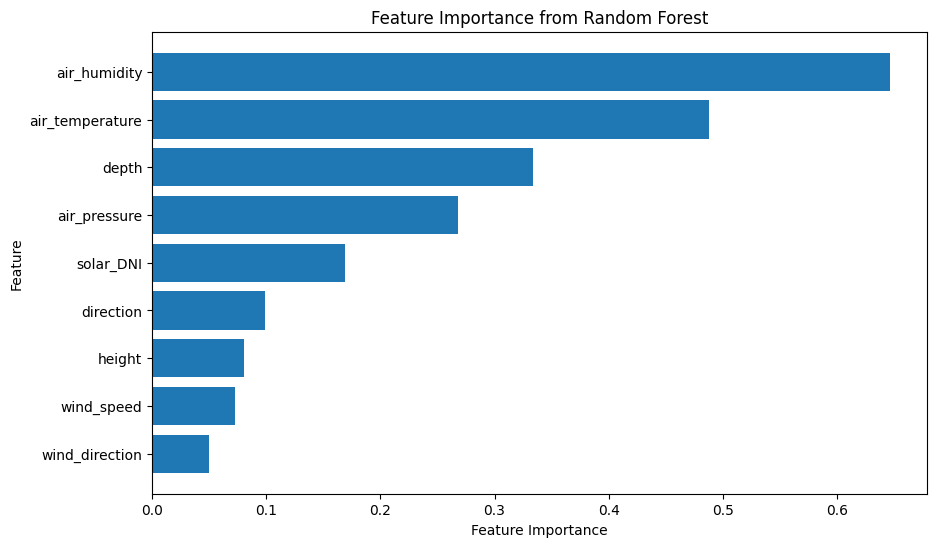

           Feature  Importance
5     air_humidity    0.646472
6  air_temperature    0.487404
1            depth    0.333969
7     air_pressure    0.267929
8        solar_DNI    0.168632
0        direction    0.099341
2           height    0.080147
3       wind_speed    0.072866
4   wind_direction    0.049609


In [18]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Display the sorted feature importance
print(feature_importance_df)


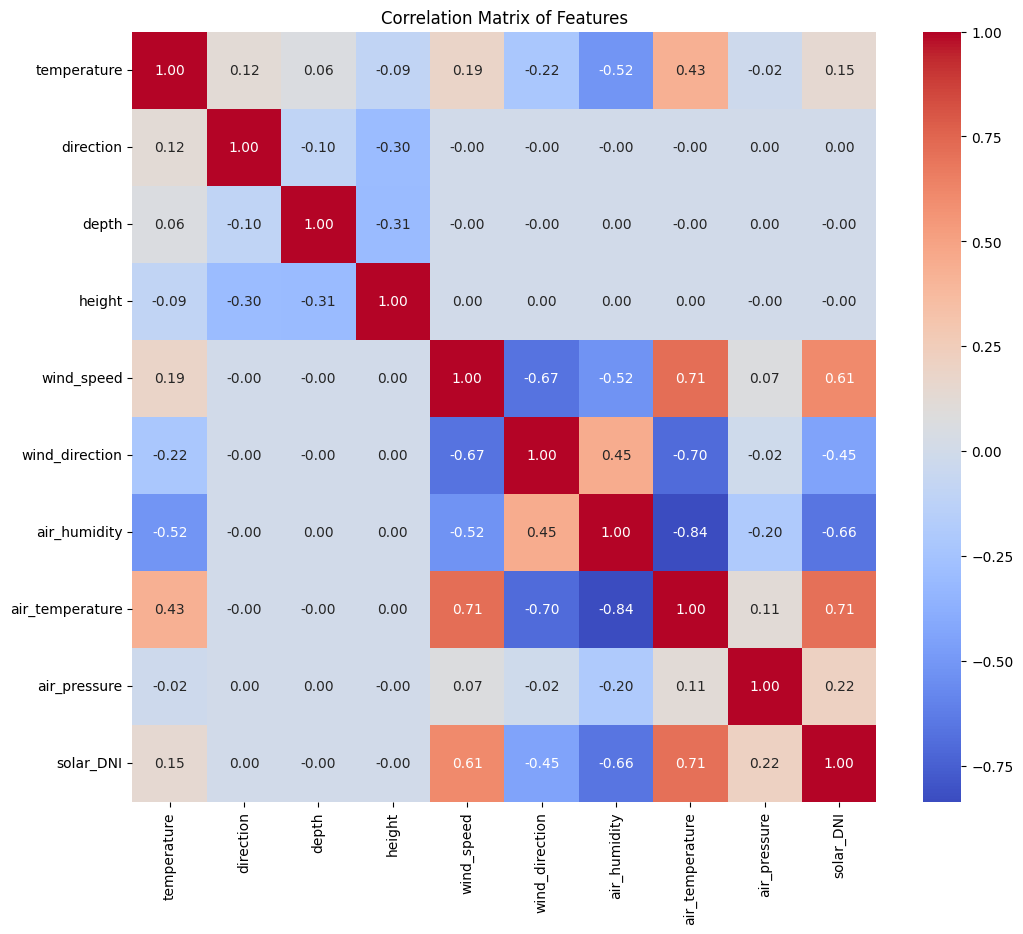

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
data = pd.read_csv('./data.csv', index_col='date_time')

# Create the scatter plot matrix
sns.pairplot(data, diag_kind='kde', hue='temperature')  # Use temperature as hue
plt.suptitle('Scatterplot Matrix with Shared Y-axis (Temperature)')
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7823ddffe660> (for post_execute):


KeyboardInterrupt: 

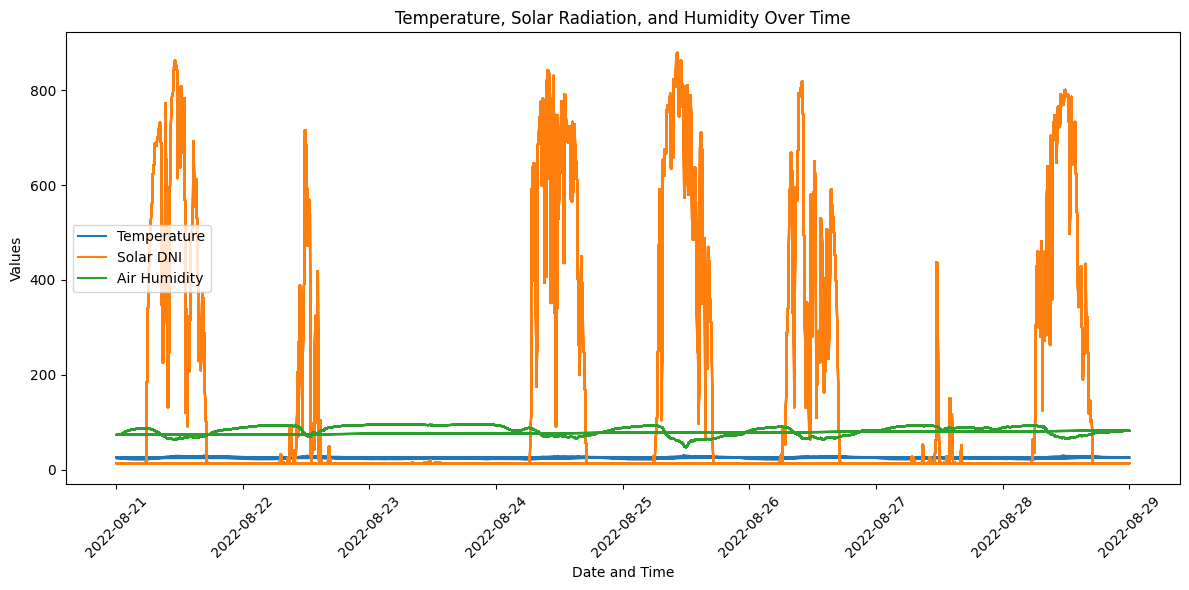

In [20]:
# prompt: Compare temp, solar, and humidity over time

import matplotlib.pyplot as plt

# Assuming 'combined' DataFrame from the previous code is available
# If not, load it: combined = pd.read_csv('./data.csv', index_col='date_time')

# Plotting temperature, solar radiation, and humidity over time
plt.figure(figsize=(12, 6))

plt.plot(combined.index, combined['temperature'], label='Temperature')
plt.plot(combined.index, combined['solar_DNI'], label='Solar DNI')
plt.plot(combined.index, combined['air_humidity'], label='Air Humidity')


plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.title('Temperature, Solar Radiation, and Humidity Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


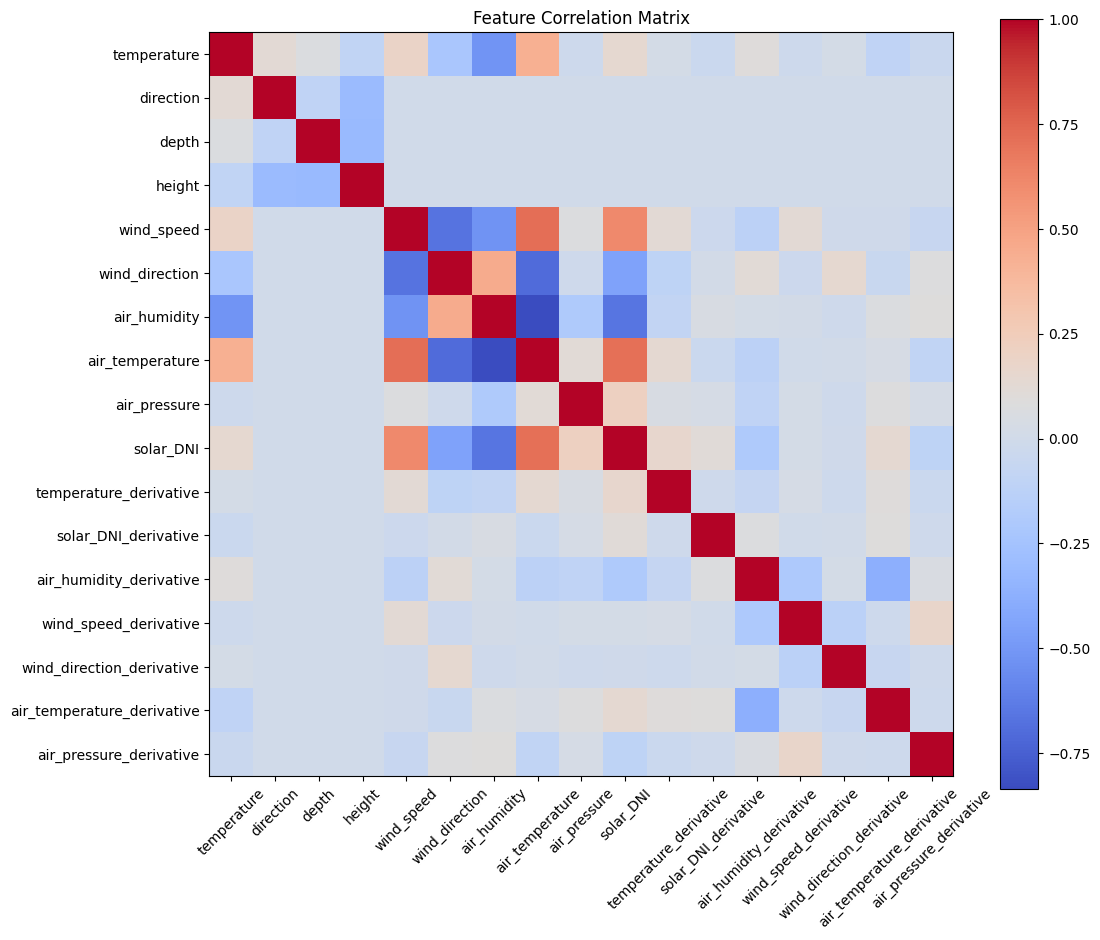

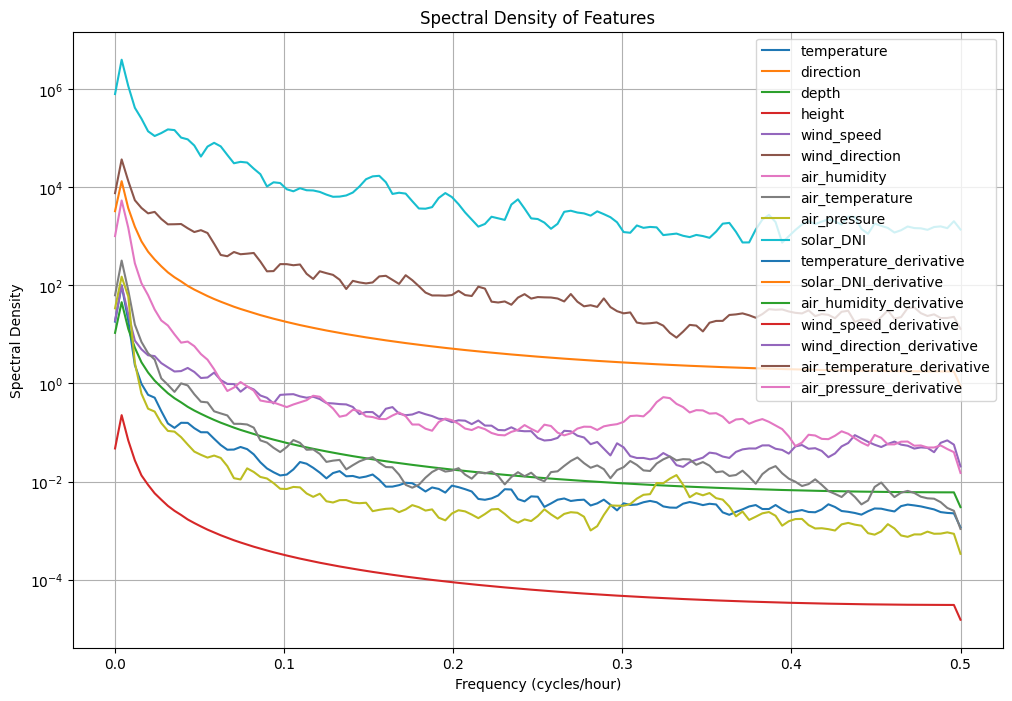

Ranked Features by Maximum Spectral Density:
solar_DNI: 3980540.8760090354
wind_direction: 36921.24415314526
direction: 13293.726857873055
air_humidity: 5375.315769166167
air_temperature: 320.0216480492216
air_pressure: 150.1729725724491
temperature: 100.0036130729044
wind_speed: 99.08116928195065
depth: 45.35772356357653
height: 0.2258143894947489
temperature_derivative: nan
solar_DNI_derivative: nan
air_humidity_derivative: nan
wind_speed_derivative: nan
wind_direction_derivative: nan
air_temperature_derivative: nan
air_pressure_derivative: nan

AUC for 'solar_DNI' vs. Temperature Threshold: 0.6453778632709097


In [21]:
import scipy.signal as signal
from sklearn.metrics import roc_auc_score


# Calculate the derivative of features over time
for col in ['temperature', 'solar_DNI', 'air_humidity', 'wind_speed', 'wind_direction', 'air_temperature', 'air_pressure']:
    combined[f'{col}_derivative'] = combined[col].diff()

# Feature correlation matrix
correlation_matrix = combined.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title('Feature Correlation Matrix')
plt.show()

# Displaying the correlation matrix numerically
correlation_matrix

# prompt: rank all freatures agisnt time using spectral denstiy, overlay plots, and find the best the AUC


# Calculate spectral density for each feature
sampling_frequency = 1
frequencies = []
spectral_densities = []

for column in combined.columns:
    if column != 'date_time' and combined[column].dtype != 'object':  # Exclude non-numeric columns and date_time
        f, Pxx_den = signal.welch(combined[column], fs=sampling_frequency)
        frequencies.append(f)
        spectral_densities.append(Pxx_den)

# Overlay plots for spectral densities
plt.figure(figsize=(12, 8))

for i, column in enumerate(combined.columns):
    if column != 'date_time' and combined[column].dtype != 'object':
        plt.semilogy(frequencies[i], spectral_densities[i], label=column)

plt.xlabel('Frequency (cycles/hour)')
plt.ylabel('Spectral Density')
plt.title('Spectral Density of Features')
plt.legend()
plt.grid(True)
plt.show()


# Example for ranking features (adjust the ranking criteria)
# Here, we rank based on the maximum spectral density.  You can adjust
# this based on what represents significance in your data.
ranked_features = sorted(
    [(col, np.max(spectral_densities[i])) for i, col in enumerate(combined.columns) if col != 'date_time' and combined[col].dtype != 'object'],
    key=lambda x: x[1],
    reverse=True,
)

print("Ranked Features by Maximum Spectral Density:")
for feature, max_density in ranked_features:
    print(f"{feature}: {max_density}")


# --- AUC Calculation (Example) ---

# Assuming 'temperature' is your target variable and you have a binary classification
# problem based on some threshold of 'temperature'.
temperature_threshold = 25 # Example threshold

# Create a binary target variable.  Replace with your classification logic.
y_true = (combined['temperature'] > temperature_threshold).astype(int)

# Choose a feature for AUC Calculation
auc_feature = 'solar_DNI' # Example feature; you can change this
y_pred_proba = combined[auc_feature]  # Use the chosen feature as the prediction probability

# Calculate the AUC
auc = roc_auc_score(y_true, y_pred_proba)
print(f"\nAUC for '{auc_feature}' vs. Temperature Threshold: {auc}")
